In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,LSTM

C:\Users\Akshay\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import yfinance as yf

In [3]:
#Download Tata motors data from yahoo finance
df = yf.download('TCS.NS')

[*********************100%***********************]  1 of 1 completed


In [4]:
#first 5 samples
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-12,38.724998,40.000000,38.724998,39.700001,28.201389,212976
2002-08-13,39.750000,40.387501,38.875000,39.162498,27.819542,153576
2002-08-14,39.250000,39.250000,35.724998,36.462502,25.901579,822776
2002-08-15,36.462502,36.462502,36.462502,36.462502,25.901579,0
2002-08-16,36.275002,38.000000,35.750000,36.375000,25.839424,811856


In [5]:
# to check dates in index
df.index

DatetimeIndex(['2002-08-12', '2002-08-13', '2002-08-14', '2002-08-15',
               '2002-08-16', '2002-08-19', '2002-08-20', '2002-08-21',
               '2002-08-22', '2002-08-23',
               ...
               '2023-07-07', '2023-07-10', '2023-07-11', '2023-07-12',
               '2023-07-13', '2023-07-14', '2023-07-17', '2023-07-18',
               '2023-07-19', '2023-07-20'],
              dtype='datetime64[ns]', name='Date', length=5202, freq=None)

In [6]:
df.shape

(5202, 6)

In [7]:
# to check features or columns 
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [8]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-07-14,3365.000000,3524.850098,3352.000000,3514.649902,3505.534180,6306101
2023-07-17,3510.000000,3549.899902,3477.050049,3491.699951,3482.643799,2743228
2023-07-18,3476.000000,3524.000000,3465.000000,3496.850098,3487.780518,2600090
2023-07-19,3500.000000,3516.850098,3445.649902,3470.050049,3461.050049,2405370
2023-07-20,3453.100098,3478.899902,3436.050049,3463.300049,3463.300049,1715146


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5202 entries, 2002-08-12 to 2023-07-20
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       5202 non-null   float64
 1   High       5202 non-null   float64
 2   Low        5202 non-null   float64
 3   Close      5202 non-null   float64
 4   Adj Close  5202 non-null   float64
 5   Volume     5202 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 284.5 KB


In [10]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [11]:
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

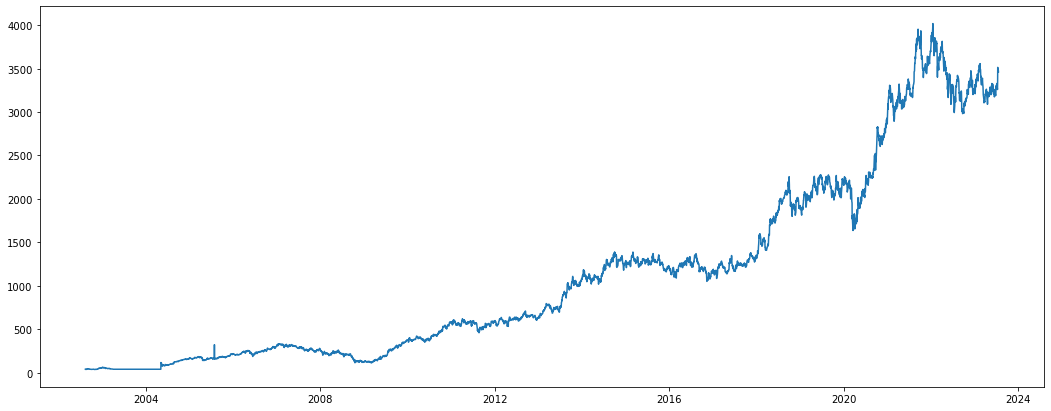

In [12]:
# plot a graph
plt1 = plt.figure(figsize=(18,7))
import matplotlib.pyplot as plt
plt.plot(df['Close'])

In [13]:
# check open price for first day and close price for last day
print("Starting price: ",df.iloc[0][0])
print("Ending price: ", df.iloc[-1][3])

Starting price:  38.724998474121094
Ending price:  3463.300048828125


In [14]:
# check start date and end date in our dataset
print("Starting date: ",df.index[0])
print("Ending date: ", df.index[-1])

Starting date:  2002-08-12 00:00:00
Ending date:  2023-07-20 00:00:00


In [15]:
# drop some columns except 'close ' columns as we are going to do prediction only on closing price
df.drop(columns=['High','Low','Adj Close','Volume'],inplace=True)

In [16]:
df.head()

,Open,Close
Date,,
2002-08-12,38.724998,39.700001
2002-08-13,39.750000,39.162498
2002-08-14,39.250000,36.462502
2002-08-15,36.462502,36.462502
2002-08-16,36.275002,36.375000


In [17]:
# LSTM are sensitive to the scale of the data. so we apply MinMax scaler 
# Preprocess the data
from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df['Close']).reshape(-1,1))

In [18]:
df1

array([[1.06057909e-03],
       [9.25652843e-04],
       [2.47887460e-04],
       ...,
       [8.68889953e-01],
       [8.62162484e-01],
       [8.60468069e-01]])

In [19]:
# Split data into training and testing sets
train_size=int(len(df1)*0.7)
test_size=len(df1)-train_size
train_data,test_data=df1[0:train_size,:],df1[train_size:len(df1),:1]

In [20]:
train_size,test_size

(3641, 1561)

In [21]:
train_data

array([[1.06057909e-03],
       [9.25652843e-04],
       [2.47887460e-04],
       ...,
       [2.95738233e-01],
       [2.93836735e-01],
       [2.96083392e-01]])

In [22]:
# convert an array of values into a dataset matrix
#function to create new dataset which is required by LSTM.giving sequence of data to our LSTM model
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), numpy.array(dataY)

In [23]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
import numpy
time_step = 20
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
X_train

array([[1.06057909e-03, 9.25652843e-04, 2.47887460e-04, ...,
        1.97368090e-03, 1.90778677e-03, 1.50614700e-03],
       [9.25652843e-04, 2.47887460e-04, 2.47887460e-04, ...,
        1.90778677e-03, 1.50614700e-03, 1.37122171e-03],
       [2.47887460e-04, 2.47887460e-04, 2.25922433e-04, ...,
        1.50614700e-03, 1.37122171e-03, 1.37122171e-03],
       ...,
       [3.00526544e-01, 2.93767697e-01, 3.02591214e-01, ...,
        3.02365286e-01, 3.03206212e-01, 3.02233492e-01],
       [2.93767697e-01, 3.02591214e-01, 3.03601594e-01, ...,
        3.03206212e-01, 3.02233492e-01, 2.99898983e-01],
       [3.02591214e-01, 3.03601594e-01, 3.00639493e-01, ...,
        3.02233492e-01, 2.99898983e-01, 2.95738233e-01]])

In [25]:
y_train

array([0.00137122, 0.00137122, 0.00163166, ..., 0.29989898, 0.29573823,
       0.29383673])

In [26]:
X_test

array([[0.29792216, 0.29747031, 0.2963156 , ..., 0.28121647, 0.28107215,
        0.28010568],
       [0.29747031, 0.2963156 , 0.29379279, ..., 0.28107215, 0.28010568,
        0.27640306],
       [0.2963156 , 0.29379279, 0.2924812 , ..., 0.28010568, 0.27640306,
        0.2785054 ],
       ...,
       [0.78807257, 0.79698394, 0.80132667, ..., 0.80940965, 0.82965481,
        0.87335814],
       [0.79698394, 0.80132667, 0.80898292, ..., 0.82965481, 0.87335814,
        0.86759714],
       [0.80132667, 0.80898292, 0.80403775, ..., 0.87335814, 0.86759714,
        0.86888995]])

In [27]:
print(X_train.shape) 

(3620, 20)


In [28]:
print(y_train.shape)

(3620,)


In [29]:
print(X_test.shape)

(1540, 20)


In [30]:
print(ytest.shape)

(1540,)


In [31]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [32]:
X_train.shape

(3620, 20, 1)

In [33]:
X_train

array([[[1.06057909e-03],
        [9.25652843e-04],
        [2.47887460e-04],
        ...,
        [1.97368090e-03],
        [1.90778677e-03],
        [1.50614700e-03]],

       [[9.25652843e-04],
        [2.47887460e-04],
        [2.47887460e-04],
        ...,
        [1.90778677e-03],
        [1.50614700e-03],
        [1.37122171e-03]],

       [[2.47887460e-04],
        [2.47887460e-04],
        [2.25922433e-04],
        ...,
        [1.50614700e-03],
        [1.37122171e-03],
        [1.37122171e-03]],

       ...,

       [[3.00526544e-01],
        [2.93767697e-01],
        [3.02591214e-01],
        ...,
        [3.02365286e-01],
        [3.03206212e-01],
        [3.02233492e-01]],

       [[2.93767697e-01],
        [3.02591214e-01],
        [3.03601594e-01],
        ...,
        [3.03206212e-01],
        [3.02233492e-01],
        [2.99898983e-01]],

       [[3.02591214e-01],
        [3.03601594e-01],
        [3.00639493e-01],
        ...,
        [3.02233492e-01],
        [2.9989

In [34]:
### Create the Stacked LSTM model
import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model

In [35]:
#model=Sequential()
#model.add(LSTM(100, input_shape = (time_step , 1)))
#model.add(Dropout(0.2))
#model.add(LSTM(200, input_shape=(time_step , 1), return_sequences=False))
#model.add(Dropout(0.5))
#model.add(Dense(100,kernel_initializer='uniform',activation='sigmoid'))        
#model.add(Dense(1,kernel_initializer='uniform',activation='sigmoid'))
#model.compile(loss='mse',optimizer='adam')

model=Sequential()
model.add(LSTM(50,input_shape=(time_step,1)))
model.add(Dropout(0.2))
#model.add(LSTM(50,return_sequences=True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [37]:
history = model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
114/114 [==============================] - 5s 19ms/step - loss: 0.0015 - val_loss: 5.0020e-04
Epoch 2/100
114/114 [==============================] - 2s 14ms/step - loss: 2.6781e-04 - val_loss: 5.3712e-04
Epoch 3/100
114/114 [==============================] - 2s 14ms/step - loss: 1.9755e-04 - val_loss: 4.6603e-04
Epoch 4/100
114/114 [==============================] - 1s 13ms/step - loss: 1.8050e-04 - val_loss: 5.6019e-04
Epoch 5/100
114/114 [==============================] - 1s 13ms/step - loss: 1.7207e-04 - val_loss: 6.2459e-04
Epoch 6/100
114/114 [==============================] - 1s 13ms/step - loss: 1.4550e-04 - val_loss: 3.3780e-04
Epoch 7/100
114/114 [==============================] - 2s 13ms/step - loss: 1.3219e-04 - val_loss: 4.7115e-04
Epoch 8/100
114/114 [==============================] - 2s 15ms/step - loss: 1.3953e-04 - val_loss: 6.0996e-04
Epoch 9/100
114/114 [==============================] - 2s 15ms/step - loss: 1.2717e-04 - val_loss: 0.0015
Epoch 10/100
114/1

114/114 [==============================] - 2s 13ms/step - loss: 7.8702e-05 - val_loss: 2.0952e-04
Epoch 76/100
114/114 [==============================] - 2s 18ms/step - loss: 7.2302e-05 - val_loss: 4.9804e-04
Epoch 77/100
114/114 [==============================] - 2s 14ms/step - loss: 7.3366e-05 - val_loss: 3.0512e-04
Epoch 78/100
114/114 [==============================] - 2s 14ms/step - loss: 8.1857e-05 - val_loss: 6.6184e-04
Epoch 79/100
114/114 [==============================] - 2s 14ms/step - loss: 7.4812e-05 - val_loss: 9.7058e-04
Epoch 80/100
114/114 [==============================] - 2s 14ms/step - loss: 8.3264e-05 - val_loss: 2.5816e-04
Epoch 81/100
114/114 [==============================] - 2s 16ms/step - loss: 7.2548e-05 - val_loss: 1.2183e-04
Epoch 82/100
114/114 [==============================] - 2s 13ms/step - loss: 7.8654e-05 - val_loss: 1.5569e-04
Epoch 83/100
114/114 [==============================] - 1s 13ms/step - loss: 8.0957e-05 - val_loss: 1.5967e-04
Epoch 84/100
1

In [38]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 [==============================] - 0s 5ms/step


In [39]:
train_predict

array([[0.00286492],
       [0.00264939],
       [0.00252963],
       ...,
       [0.29700425],
       [0.29536813],
       [0.29234967]], dtype=float32)

In [40]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [41]:
train_predict

array([[  46.88791 ],
       [  46.029305],
       [  45.55222 ],
       ...,
       [1218.6433  ],
       [1212.1256  ],
       [1200.101   ]], dtype=float32)

In [42]:
test_predict

array([[1134.6875],
       [1125.1299],
       [1124.2926],
       ...,
       [3308.5908],
       [3350.743 ],
       [3365.9375]], dtype=float32)

In [43]:
ytest

array([0.27640306, 0.2785054 , 0.28445469, ..., 0.86759714, 0.86888995,
       0.86216248])

In [44]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))


666.1789696422485

In [45]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

2532.232449052261

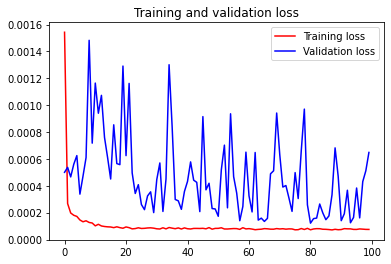

<Figure size 432x288 with 0 Axes>

In [46]:
### plot a graph for training and validation loss to visualize the results of model training

import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc='best')
plt.figure()


plt.show()

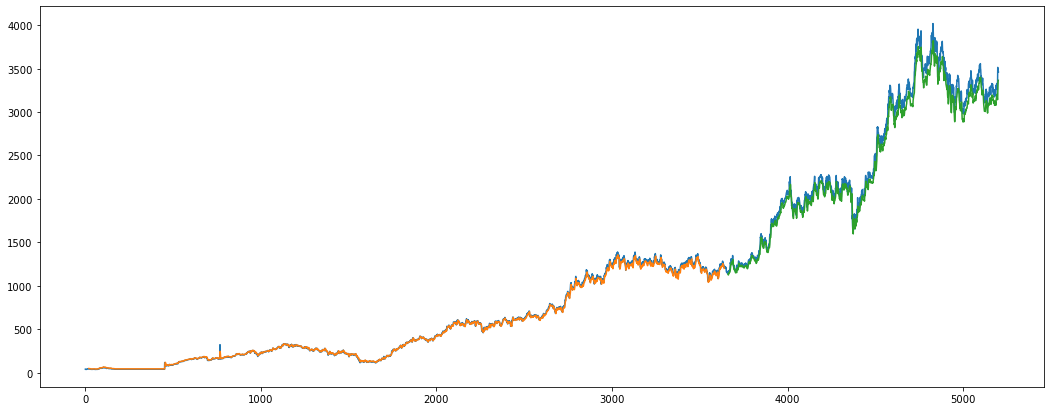

In [47]:
# shift train predictions for plotting
look_back=20
trainPredictPlot = numpy.empty_like(df1)  ## to take same shape and sata type of df1
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt1 = plt.figure(figsize=(18,7))
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [48]:
ytest

array([0.27640306, 0.2785054 , 0.28445469, ..., 0.86759714, 0.86888995,
       0.86216248])

In [49]:
test_predict

array([[1134.6875],
       [1125.1299],
       [1124.2926],
       ...,
       [3308.5908],
       [3350.743 ],
       [3365.9375]], dtype=float32)

In [50]:
test_predict1 = test_predict.flatten()

In [51]:
len(ytest)

1540

In [52]:
test_predict1

array([1134.6875, 1125.1299, 1124.2926, ..., 3308.5908, 3350.743 ,
       3365.9375], dtype=float32)

In [53]:
ytest1 = ytest.flatten()

In [54]:
ytest1 = ytest1.reshape(1,-1)

In [55]:
ytest1

array([[0.27640306, 0.2785054 , 0.28445469, ..., 0.86759714, 0.86888995,
        0.86216248]])

In [56]:
ytest2 = scaler.inverse_transform(ytest1)

In [57]:
ytest2

array([[1136.57495117, 1144.94995117, 1168.65002441, ..., 3491.69995117,
        3496.85009766, 3470.05004883]])

In [58]:
ytest2 = ytest2.flatten()

In [59]:
len(ytest2)

1540

In [60]:
df2 = df.iloc[3662:,:]

In [61]:
len(df2)

1540

In [62]:
df2.head()

,Open,Close
Date,,
2017-05-02,1147.000000,1144.949951
2017-05-03,1147.500000,1168.650024
2017-05-04,1174.974976,1165.050049
2017-05-05,1154.000000,1160.250000
2017-05-08,1160.500000,1171.224976


In [63]:
df2['predicted'] = test_predict1

In [64]:
df2.head(20)

,Open,Close,predicted
Date,,,
2017-05-02,1147.000000,1144.949951,1134.687500
2017-05-03,1147.500000,1168.650024,1125.129883
2017-05-04,1174.974976,1165.050049,1124.292603
2017-05-05,1154.000000,1160.250000,1137.297485
2017-05-08,1160.500000,1171.224976,1143.421509
2017-05-09,1171.974976,1176.275024,1143.707642
2017-05-10,1177.500000,1166.224976,1148.949585
2017-05-11,1173.650024,1174.724976,1154.309082
2017-05-12,1171.650024,1180.324951,1151.497192


In [65]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1540 entries, 2017-05-02 to 2023-07-20
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1540 non-null   float64
 1   Close      1540 non-null   float64
 2   predicted  1540 non-null   float32
dtypes: float32(1), float64(2)
memory usage: 42.1 KB


In [66]:
df2.tail()

,Open,Close,predicted
Date,,,
2023-07-14,3365.000000,3514.649902,3142.417725
2023-07-17,3510.000000,3491.699951,3185.002686
2023-07-18,3476.000000,3496.850098,3308.590820
2023-07-19,3500.000000,3470.050049,3350.742920
2023-07-20,3453.100098,3463.300049,3365.937500


In [67]:
df2['temp_signal'] = df2['predicted'] - df2['Close']

In [68]:
df2.head()

,Open,Close,predicted,temp_signal
Date,,,,
2017-05-02,1147.000000,1144.949951,1134.687500,-10.262451
2017-05-03,1147.500000,1168.650024,1125.129883,-43.520142
2017-05-04,1174.974976,1165.050049,1124.292603,-40.757446
2017-05-05,1154.000000,1160.250000,1137.297485,-22.952515
2017-05-08,1160.500000,1171.224976,1143.421509,-27.803467


In [69]:
df2['signal'] = df2['temp_signal'].apply(lambda x:1 if x>0 else 0)

In [70]:
df2.head()

,Open,Close,predicted,temp_signal,signal
Date,,,,,
2017-05-02,1147.000000,1144.949951,1134.687500,-10.262451,0
2017-05-03,1147.500000,1168.650024,1125.129883,-43.520142,0
2017-05-04,1174.974976,1165.050049,1124.292603,-40.757446,0
2017-05-05,1154.000000,1160.250000,1137.297485,-22.952515,0
2017-05-08,1160.500000,1171.224976,1143.421509,-27.803467,0


In [71]:
df2.drop(columns='temp_signal',inplace = True)

In [72]:
df2.head()

,Open,Close,predicted,signal
Date,,,,
2017-05-02,1147.000000,1144.949951,1134.687500,0
2017-05-03,1147.500000,1168.650024,1125.129883,0
2017-05-04,1174.974976,1165.050049,1124.292603,0
2017-05-05,1154.000000,1160.250000,1137.297485,0
2017-05-08,1160.500000,1171.224976,1143.421509,0


In [73]:
signal = list(df2['signal'])

In [74]:
signal

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [75]:
signal.insert(0,999)

In [76]:
signal

[999,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0

In [77]:
len(df2)

1540

In [78]:
len(signal)

1541

In [79]:
signal.pop()

0

In [80]:
len(signal)

1540

In [81]:
new_signal = np.array(signal)

In [82]:
new_signal

array([999,   0,   0, ...,   0,   0,   0])

In [83]:
df2['new_signal'] = new_signal

In [84]:
df2.head()

,Open,Close,predicted,signal,new_signal
Date,,,,,
2017-05-02,1147.000000,1144.949951,1134.687500,0,999
2017-05-03,1147.500000,1168.650024,1125.129883,0,0
2017-05-04,1174.974976,1165.050049,1124.292603,0,0
2017-05-05,1154.000000,1160.250000,1137.297485,0,0
2017-05-08,1160.500000,1171.224976,1143.421509,0,0


In [85]:
df2.drop(columns = 'signal',inplace = True)

In [86]:
df3 = df2[df2['new_signal']==1]

In [87]:
df3.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-06-09,1260.000000,1253.500000,1296.473511,1
2017-06-12,1248.500000,1243.599976,1266.135376,1
2017-06-13,1232.500000,1225.775024,1243.746338,1
2017-06-14,1227.500000,1235.099976,1227.181763,1
2017-06-16,1207.474976,1199.849976,1208.124146,1


In [88]:
df3['profit_loss'] = df3['Close'] - df3['Open']

In [89]:
df3.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-06-09,1260.000000,1253.500000,1296.473511,1,-6.500000
2017-06-12,1248.500000,1243.599976,1266.135376,1,-4.900024
2017-06-13,1232.500000,1225.775024,1243.746338,1,-6.724976
2017-06-14,1227.500000,1235.099976,1227.181763,1,7.599976
2017-06-16,1207.474976,1199.849976,1208.124146,1,-7.625000


In [90]:
df3['profit_loss'].sum()

-303.1495361328125

In [91]:
df4 = df2[df2['new_signal']==0]

In [92]:
df4['profit_loss'] = df4['Open'] - df4['Close']

In [93]:
df4.head()

,Open,Close,predicted,new_signal,profit_loss
Date,,,,,
2017-05-03,1147.500000,1168.650024,1125.129883,0,-21.150024
2017-05-04,1174.974976,1165.050049,1124.292603,0,9.924927
2017-05-05,1154.000000,1160.250000,1137.297485,0,-6.250000
2017-05-08,1160.500000,1171.224976,1143.421509,0,-10.724976
2017-05-09,1171.974976,1176.275024,1143.707642,0,-4.300049


In [94]:
df2.head()

,Open,Close,predicted,new_signal
Date,,,,
2017-05-02,1147.000000,1144.949951,1134.687500,999
2017-05-03,1147.500000,1168.650024,1125.129883,0
2017-05-04,1174.974976,1165.050049,1124.292603,0
2017-05-05,1154.000000,1160.250000,1137.297485,0
2017-05-08,1160.500000,1171.224976,1143.421509,0


In [95]:
df2.tail()

,Open,Close,predicted,new_signal
Date,,,,
2023-07-14,3365.000000,3514.649902,3142.417725,0
2023-07-17,3510.000000,3491.699951,3185.002686,0
2023-07-18,3476.000000,3496.850098,3308.590820,0
2023-07-19,3500.000000,3470.050049,3350.742920,0
2023-07-20,3453.100098,3463.300049,3365.937500,0


In [96]:
df4['profit_loss'].sum()

1358.9990234375

In [97]:
Total_profit = df4['profit_loss'].sum() + df3['profit_loss'].sum()

In [98]:
Total_profit

1055.8494873046875

In [99]:
# check open price for first day and close price for last day
print("Starting price: ",df2.iloc[0][0])
print("Ending price: ", df2.iloc[-1][2])

Starting price:  1147.0
Ending price:  3365.9375


In [100]:
# total profit if buy and hold

buy_hold_profit = df2.iloc[-1][2] - df2.iloc[0][0]
buy_hold_profit

2218.9375

In [101]:
# excess profit generated by algo model

excess_profit = Total_profit - buy_hold_profit
excess_profit

-1163.0880126953125

In [102]:
len(df3)

93

In [103]:
len(df4)

1446

In [104]:
len(df2)

1540